# GPAO II

We have pre-implemented automation code that does OIM addition to target energy adjusting. We use `GPAO` wrapper class that uses `DAO` as `real_finder`. 



Unfortunately, this process generates folder in the user's directory rather than put out info on the `sys.io`. That is because it genrates a lot of info and 

KeyboardInterrupt: 

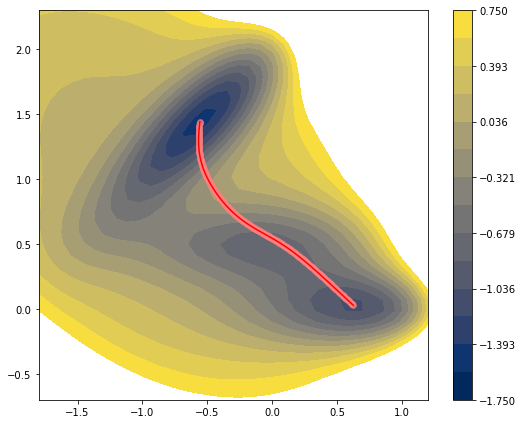

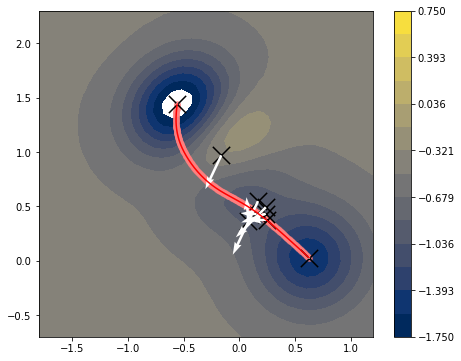

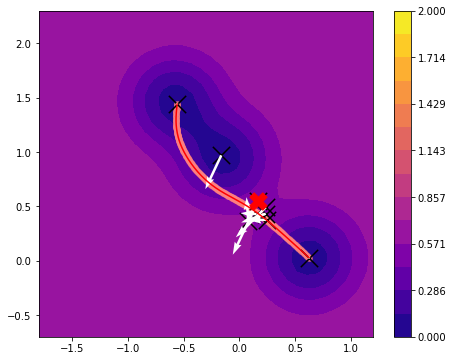

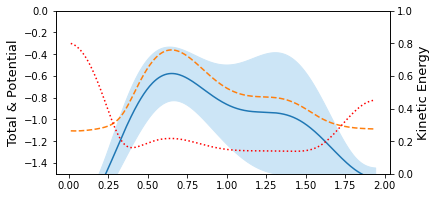

In [2]:
import numpy as np
from taps.paths import Paths
from taps.models import MullerBrown, Gaussian
from taps.pathfinder import DAO, GPAO
from taps.coords import Cartesian
from taps.visualize import view
from taps.ml.regressions import Regression
from taps.projectors import Sine
from taps.db import ImageDatabase

# We are going to use only the 30% of the coordinate information
name = "AuGPAO"
#trialn = "test9/"
trialn = "test/"
#directory = name + '/'
directory = './'


N = 300

x = np.linspace(-0.55822365, 0.6234994, N)
y = np.linspace(1.44172582, 0.02803776, N)

coords = Cartesian(coords=np.array([x, y]))

Nk = N - 270
prj = Sine(N=N, Nk=Nk, 
           init=coords.coords[..., 0].copy(), 
           fin=coords.coords[..., -1].copy())



action_kwargs = {
    'Onsager Machlup':{    
        'gam': 1.,
    },
    'Energy Restraint':{
        'muE': 1.,
        'Et': -0.45
    }
}

search_kwargs = {"method":"L-BFGS-B"}


finder = DAO(action_kwargs=action_kwargs,
             search_kwargs=search_kwargs, 
             prj=prj)

maxtrial=200

plot_kwargs = {"savefig":True, "gaussian": True, 'viewer': 'MullerBrown'}

finder = GPAO(real_finder=finder, maxtrial=maxtrial, 
              logfile=directory+trialn + name +'.log',
              label= directory + trialn + name,
              phase_kwargs={"Auto Et":{'Et_tol':0.05, 'cov_tol':0.01, 'Etol': 0.05}, 
                                "Auto Et":{'Et_tol':0.05, 'cov_tol':0.01, 'Etol': 0.05}},
                  plot_kwargs=plot_kwargs)


imgdb = ImageDatabase(filename="mullerbrown.db")


model = MullerBrown()

model = Gaussian(real_model=model)

paths = Paths(coords=coords, model=model, finder=finder, imgdb=imgdb)

def regression(model, database):
    from scipy.optimize import minimize, Bounds
    from taps.models.gaussian import Likelihood
    loss_fn = Likelihood(kernel=model.kernel, mean=model.mean, database=database, kernel_prj=model.prj)
    x0 = model.kernel.get_hyperparameters()
    # sigma_f, l^2, sigma_n^e, sigma_n^f
    bounds = Bounds([1e-2, 1e-2, 1e-5, 1e-6], [5e1, 1e2, 1e-2, 1e-3])
    res = minimize(loss_fn, x0, bounds=bounds, method='L-BFGS-B')
    model.set_lambda(database, Θk=res.x)

    
paths.add_image_data(index=[0, coords.N//3, -1])
regression(model, imgdb)
paths.search()


In [3]:
pdb.write([{'paths': paths}])

[1]

In [4]:
paths.get_masses()

1.0

In [5]:
aa = pdb.read(ids=[1])